# Survival analysis for liver values

In [1]:
import ehrapy as ep
import pandas as pd
import numpy as np

Installed version 0.4.0 of ehrapy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

/home/zeth/miniconda3/envs/ehrapy/lib/python3.10/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
adata = ep.io.read_h5ad(
    "../../../anndata_objects/adata_02_2023_pneumonia_unspecified_rest.h5ad"
)
adata

AnnData object with n_obs × n_vars = 277 × 254
    obs: ' Dexmedetomidine Hydrochloride Injection', '(4:1)Glucose and Sodium Chloride Injection', '0.9% Sodium Chloride Injection', '10% Calcium Gluconate Injection', '10% Chloral Hydrate Enemas', '10% Chloral Hydrate Syrup', '10% Glucose Injection', '10% Potassium Chloride Injection', '10% Potassium Chloride Oral Solution', '10% Sodium Chloride Injection', '20% Albumin Prepared From Human Plasma Injection', '20% Mannitol Injection', '20% Medium and Long Chain Fat Emulsion Injection', '25% Magnesium Sulfate Injection', '5% Amino Acidi Injection', '5% Calcium Chloride Injection', '5% Glucose Injection', '5% Glucose and Sodium Chloride Injection', '5% Sodium Bicarbonate Injection', '50% Glucose Injection', '6% Dextran 40 Glucose Injection', 'Aciclovir for Injection', 'Ademetionine  1,4-Butanedisulfonate for Injection', 'Adrenaline Hydrochlaride Injection', 'Alprostadil Injection', 'Ambroxol Hydrochloride Injection', 'Ambroxol Hydrochloride 

/home/zeth/miniconda3/envs/ehrapy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


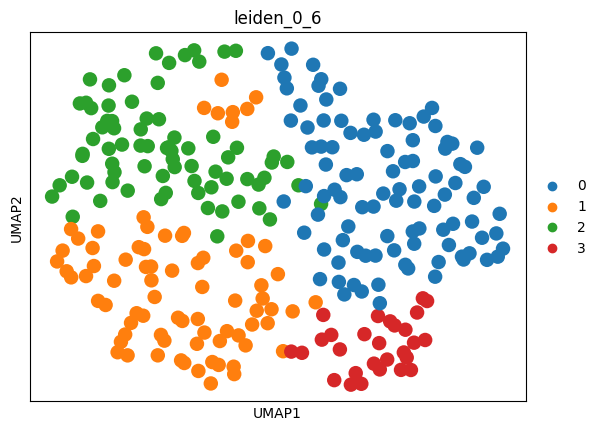

In [3]:
ep.tl.leiden(adata, resolution=0.6, key_added="leiden_0_6")
ep.pl.umap(adata, color=["leiden_0_6"])

## Kaplan Meier

In [4]:
adata.obs["gender_num"] = adata.obs["gender"].cat.rename_categories({"F": 0, "M": 1})

Filter the AnnData object by time. We only want the first 100 days of the stays.

In [5]:
adata.obs["OUTTIME"] = pd.to_datetime(adata.obs["OUTTIME"])
adata.obs["INTIME"] = pd.to_datetime(adata.obs["INTIME"])

hours_diff = (adata.obs["OUTTIME"] - adata.obs["INTIME"]).dt.total_seconds() / 3600

mask = hours_diff < 336

adata.obs["STAY_TIME_HOURS"] = hours_diff
filtered_adata = adata[mask]
filtered_adata

View of AnnData object with n_obs × n_vars = 199 × 254
    obs: ' Dexmedetomidine Hydrochloride Injection', '(4:1)Glucose and Sodium Chloride Injection', '0.9% Sodium Chloride Injection', '10% Calcium Gluconate Injection', '10% Chloral Hydrate Enemas', '10% Chloral Hydrate Syrup', '10% Glucose Injection', '10% Potassium Chloride Injection', '10% Potassium Chloride Oral Solution', '10% Sodium Chloride Injection', '20% Albumin Prepared From Human Plasma Injection', '20% Mannitol Injection', '20% Medium and Long Chain Fat Emulsion Injection', '25% Magnesium Sulfate Injection', '5% Amino Acidi Injection', '5% Calcium Chloride Injection', '5% Glucose Injection', '5% Glucose and Sodium Chloride Injection', '5% Sodium Bicarbonate Injection', '50% Glucose Injection', '6% Dextran 40 Glucose Injection', 'Aciclovir for Injection', 'Ademetionine  1,4-Butanedisulfonate for Injection', 'Adrenaline Hydrochlaride Injection', 'Alprostadil Injection', 'Ambroxol Hydrochloride Injection', 'Ambroxol Hydroc

In [6]:
def norm_values(measurements, lab_value):
    """0 if the value is in the norm range, 1 elsewise"""
    if lab_value == "AST":
        norm_range = [15, 60]
    elif lab_value == "ALT":
        norm_range = [15, 45]
    elif lab_value == "bilirubin":
        norm_range = [0.2, 1.2]
    elif lab_value == "cholestasis":
        norm_range = [0, 30]
    elif lab_value == "gGT":
        norm_range = [5, 35]
    elif lab_value == "prealbumin":
        norm_range = [15, 35]
    elif lab_value == "albumin":
        norm_range = [35, 55]
    elif lab_value == "cholinesterase":
        norm_range = [4500, 11500]
    else:
        raise ValueError("Invalid lab value entered.")

    norm_array = [
        0 if norm_range[0] <= measurement <= norm_range[1] else 1
        for measurement in measurements
    ]

    return np.array(norm_array)

In [7]:
def get_norm_values(adata):
    bilirubin_norm = norm_values(
        adata[:, "Bilirubin, Direct_max"].layers["original_imputed"], "bilirubin"
    )  # Looks better with min/avg
    g_glutamyltransferase_norm = norm_values(
        adata[:, "Gamma Glutamyltransferase_max"].layers["original_imputed"], "gGT"
    )
    albumin_norm = norm_values(
        adata[:, "Albumin_min"].layers["original_imputed"], "albumin"
    )
    alt_norm = norm_values(
        adata[:, "Alanine Aminotransferase (ALT)_max"].layers["original_imputed"], "ALT"
    )
    ast_norm = norm_values(
        adata[:, "Asparate Aminotransferase (AST)_max"].layers["original_imputed"],
        "AST",
    )
    joint_alt_ast = np.logical_or(alt_norm, ast_norm).astype(int)

    all_norm_values = {
        "Bilirubin": bilirubin_norm,
        "Gamma Glutamyltransferase": g_glutamyltransferase_norm,
        "Albumin": albumin_norm,
        "ALT": alt_norm,
        "AST": ast_norm,
        "Joint ALT AST": joint_alt_ast,
    }

    return all_norm_values

## Calculate the KMF test statistics and generate plots

In [8]:
def kmf_statistics_plot(adata, xlim=(0, 500)):
    all_norm_values = get_norm_values(adata)

    for name, measurement in all_norm_values.items():
        T = np.array(adata.obs.STAY_TIME_HOURS)  # should be in days -> recalculate it
        E = adata[:, ["ehrapycat_Death_1"]].X
        groups = measurement
        ix1 = groups == 0
        ix2 = groups == 1
        kmf_1 = ep.tl.kmf(T[ix1], E[ix1], label=f"Inside {name} Norm")
        kmf_2 = ep.tl.kmf(T[ix2], E[ix2], label=f"Outside {name} Norm")

        log_rank_test_result = ep.tl.test_kmf_logrank(kmf_1, kmf_2)
        print(f"Test results for {name} for {len(adata.obs)} patients:")
        print(f"p-value of {log_rank_test_result.p_value}")

        ep.pl.kmf(
            [kmf_1, kmf_2],
            color=["k", "r"],
            xlim=xlim,
            ylim=[0, 1],
            xlabel="Hours",
            ylabel="Proportion Who Survived",
            show=True,
        )

Test results for Bilirubin for 277 patients:
p-value of 0.5576350490875956
Test results for Gamma Glutamyltransferase for 277 patients:
p-value of 0.7245511778179892
Test results for Albumin for 277 patients:
p-value of 0.10680044063903403
Test results for ALT for 277 patients:
p-value of 0.014384258841554578
Test results for AST for 277 patients:
p-value of 0.03178008168090167
Test results for Joint ALT AST for 277 patients:
p-value of 0.25659679649791767


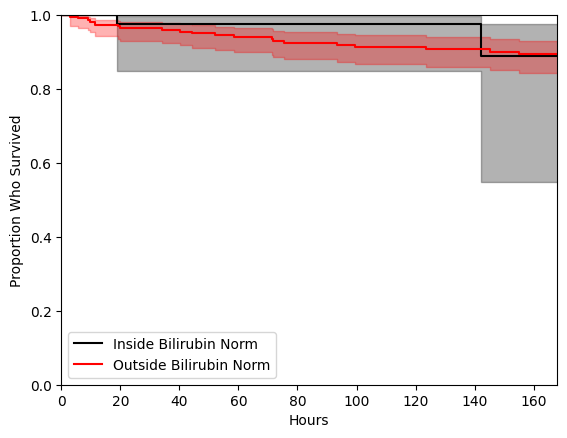

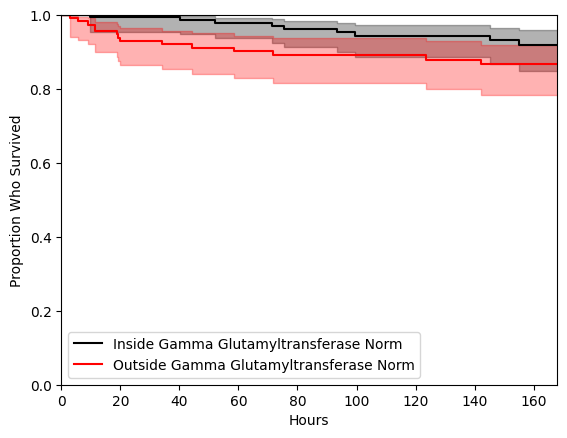

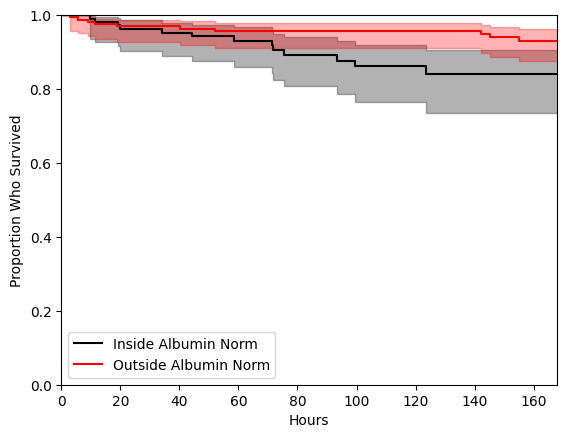

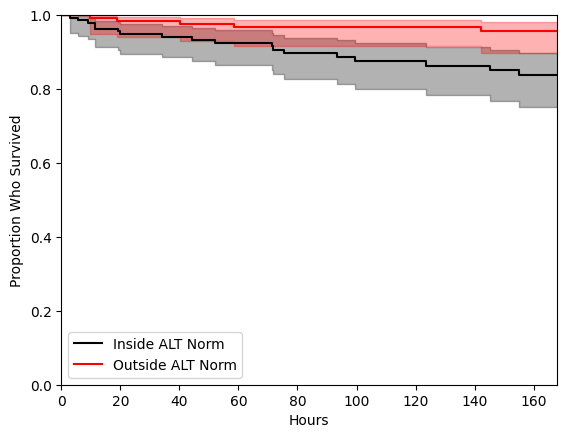

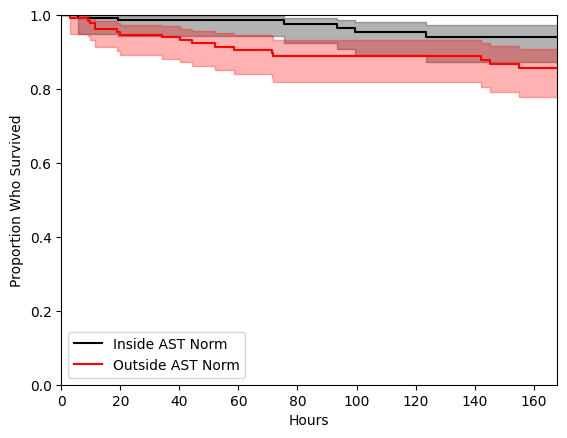

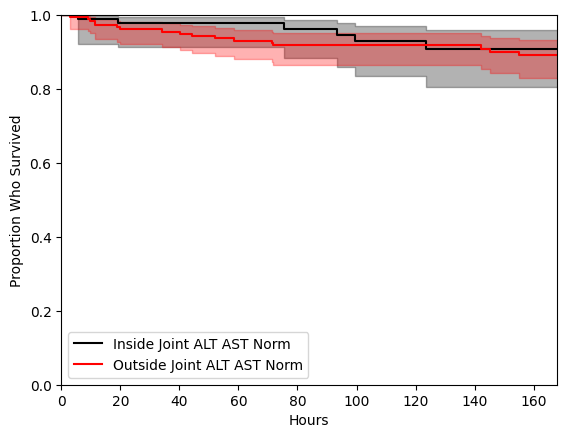

In [9]:
kmf_statistics_plot(adata, xlim=(0, 168))

Test results for Bilirubin for 199 patients:
p-value of 0.16832251239267668
Test results for Gamma Glutamyltransferase for 199 patients:
p-value of 0.016517890592122848
Test results for Albumin for 199 patients:
p-value of 0.34055835270721246
Test results for ALT for 199 patients:
p-value of 0.2007446436921521
Test results for AST for 199 patients:
p-value of 0.00038027567226994117
Test results for Joint ALT AST for 199 patients:
p-value of 0.050107185759104896


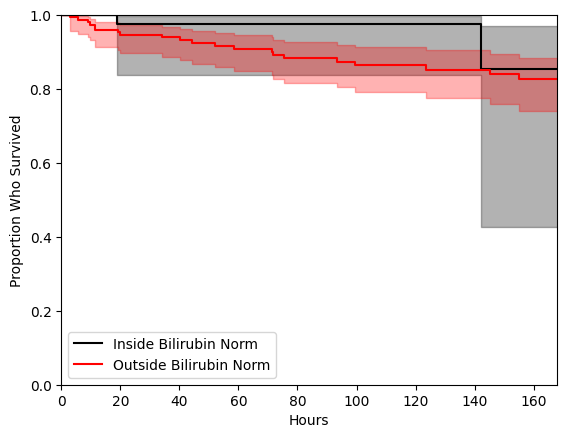

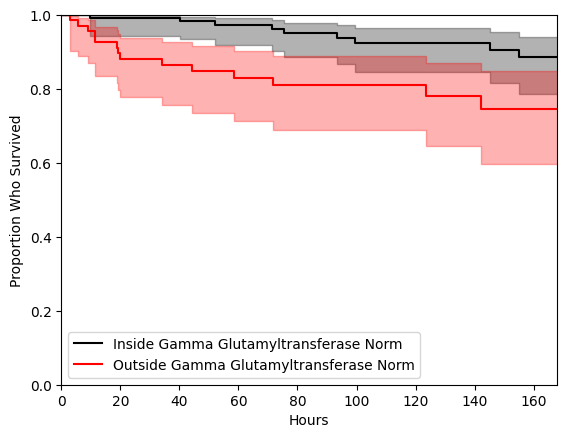

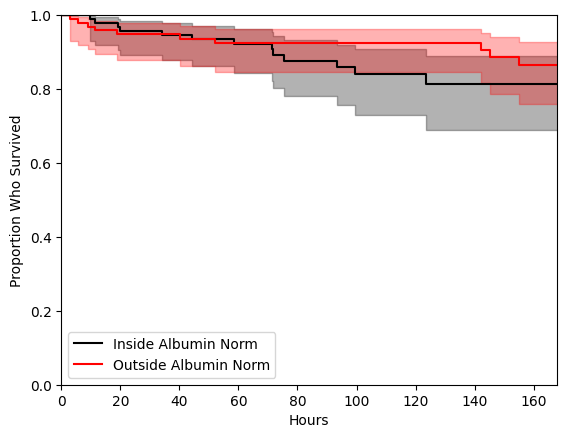

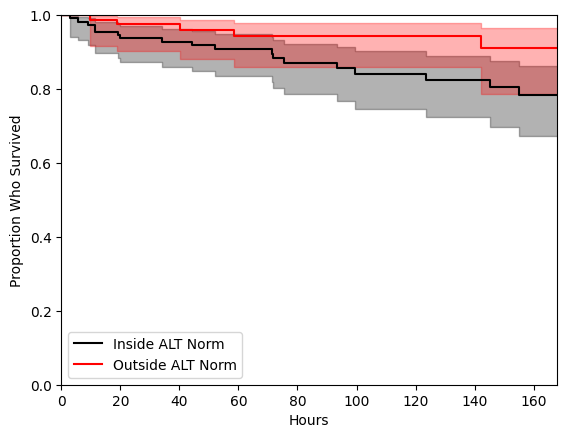

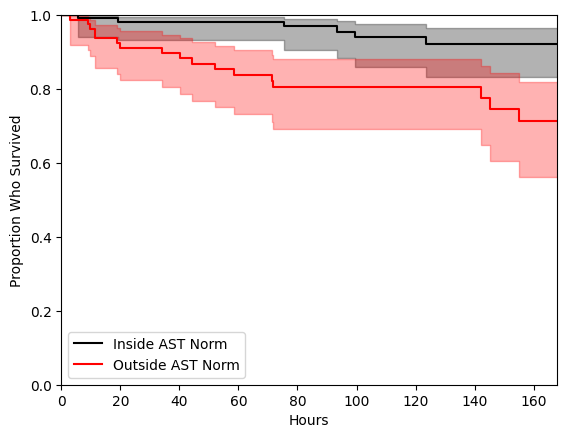

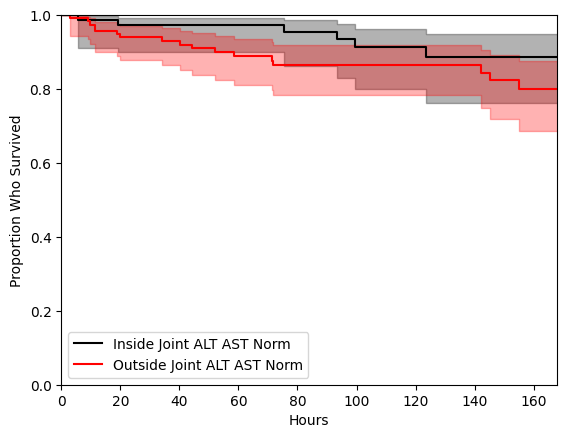

In [10]:
kmf_statistics_plot(filtered_adata, xlim=(0, 168))